In [1]:
pip install sympy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import truncnorm
from scipy.stats import norm

<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
/var/folders/zc/wvk_7mm96ql1xtbm8mtvdc580000gn/T/ipykernel_90878/4242581908.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Normalized PDF $g(x)$ for Different $L$ and $\eta$ Values')


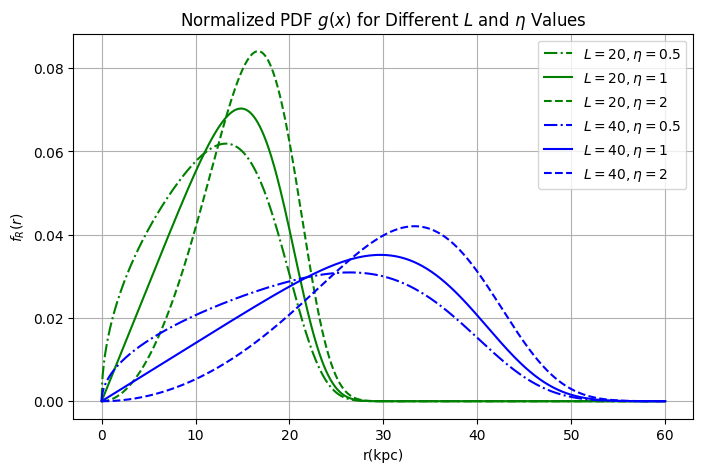

In [3]:
def g_x(x, L, n):
    return (6 / (L**(n+1) * gamma((n+1)/ 3))) * x**n * np.exp(-(x/ L)** 6)

def comp_norm(L, n):
    integral, _= quad(lambda x: g_x(x, L, n), 0,np.inf)  
    return integral

def g_x_norm(x, L, n):
    norm_factor = comp_norm(L, n)
    return g_x(x, L, n)/ norm_factor  

x_vals = np.linspace(0,60,1000)  

L_values = [20, 40]
eta_values = [0.5, 1, 2]
line_styles = {0.5: 'dashdot', 1: 'solid', 2: 'dashed'}
colors = {20: 'green', 40: 'blue'}

plt.figure(figsize=(8, 5))

for L in L_values:
    for eta in eta_values:
        plt.plot(x_vals, g_x_norm(x_vals, L, eta), linestyle=line_styles[eta],color=colors[L],label=rf'$L={L},  \eta={eta}$')

plt.xlabel('r(kpc)')
plt.ylabel(r'$f_{R}(r)$')
plt.title('Normalized PDF $g(x)$ for Different $L$ and $\eta$ Values')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


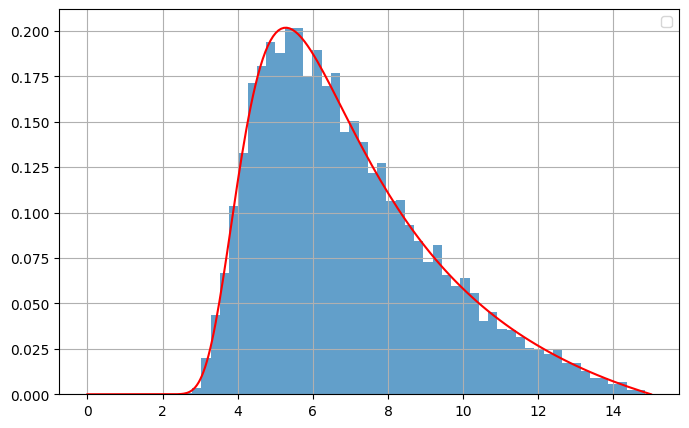

In [4]:
x, z= sp.symbols('x z')

L= 25  
g_1= (6 / (L**2 * gamma(1 / 3))) *x * sp.exp(-(x / L) ** 6)
g_numeric_1 =sp.lambdify(x, g_1, modules=['numpy'])

integral_1, _= quad(g_numeric_1, 0, np.inf)
g_1= g_1/ integral_1  

trans_1= -20* sp.ln(z/ 15)
f_1= g_1.subs(x, trans_1) * sp.Abs(sp.diff(trans_1, z))
f_np_1 = sp.lambdify(z,f_1, modules=['numpy',{'log': np.log, 'Abs': np.abs}])

z_vals_1 =np.geomspace(1e-5,15,  1000) 
y_vals_1= f_np_1(z_vals_1)

norma_1= np.trapz(y_vals_1, z_vals_1)
f_np_corr_1 =lambda z: f_np_1(z) / norma_1

evals_f_vals_1= np.column_stack((z_vals_1, f_np_corr_1(z_vals_1)))

def proposal_pdf(x, mu, sigma, a, b):
    return truncnorm.pdf(x, (a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)

mu, sigma = 5, 3  
a, b= 1e-5, 15  
proposal_vals= proposal_pdf(z_vals_1, mu, sigma, a,b)

M= np.max(f_np_corr_1(z_vals_1)/ proposal_vals)

def rejection_sampling(num_samples, target_pdf, proposal_pdf, mu, sigma, a,b, M):
    samples= []
    while len(samples) < num_samples:
        x= truncnorm.rvs((a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)
        u= np.random.uniform()
        if u<= target_pdf(x) / (M*proposal_pdf(x, mu,sigma, a, b)):
            samples.append(x)
    return np.array(samples)

num_samples= 10000
samples_1= rejection_sampling(num_samples,f_np_corr_1,proposal_pdf, mu,sigma,a,b,M)

plt.figure(figsize=(8, 5))
plt.hist(samples_1, bins=50, density=True, alpha=0.7)
plt.plot(z_vals_1, f_np_corr_1(z_vals_1), color='r')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


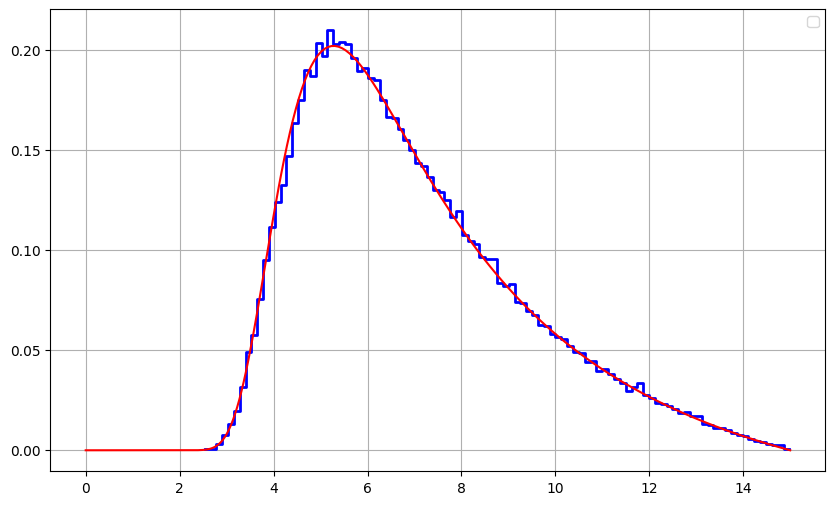

In [5]:
def g_x(x, L, n):
    return (6 / (L**(n+1) * 2.7)) * x**n * np.exp(-(x / L) ** 6)

def comp_norm(L, n):
    integral, _= quad(lambda x: g_x(x, L, n), 0, np.inf)
    return integral

def g_x_norm(x, L, n):
    norm_factor= comp_norm(L, n)
    return g_x(x, L, n) / norm_factor  

def truncated_normal(mu, sigma, a, b, size=1):
    a, b= (a-mu)/sigma, (b-mu)/sigma  
    return truncnorm.rvs(a, b, loc=mu, scale=sigma, size=size)

def sample_gx(L, n, num_samples=100000):
    samples= []
    mu, sigma= 16, 7  
    a, b= 1e-5, 50   
    while len(samples) < num_samples:
        x= truncated_normal(mu, sigma, a, b)
        u= np.random.uniform(0, 1)
        if u<= g_x_norm(x, L,n) / (1.25*truncnorm.pdf(x,(a-mu)/sigma,(b-mu)/sigma, loc=mu, scale=sigma)):  
            samples.append(x)
    return np.array(samples)

L= 25
n= 1
sampled_x = sample_gx(L, n)

B_R= 15 * np.exp(-sampled_x / 20)

def trace_histogram(data, bins=100):
    counts, edges= np.histogram(data, bins=bins, density=True)
    left, right= edges[:-1], edges[1:]
    X= np.array([left, right]).T.flatten()
    Y= np.array([counts, counts]).T.flatten()
    return X, Y

plt.figure(figsize=(10, 6))
X_BR_1, Y_BR_1= trace_histogram(B_R)

BRR_1= np.column_stack((X_BR_1, Y_BR_1))

plt.plot(X_BR_1, Y_BR_1, color='b', linewidth=2)
plt.plot(z_vals_1, f_np_corr_1(z_vals_1),color='r')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


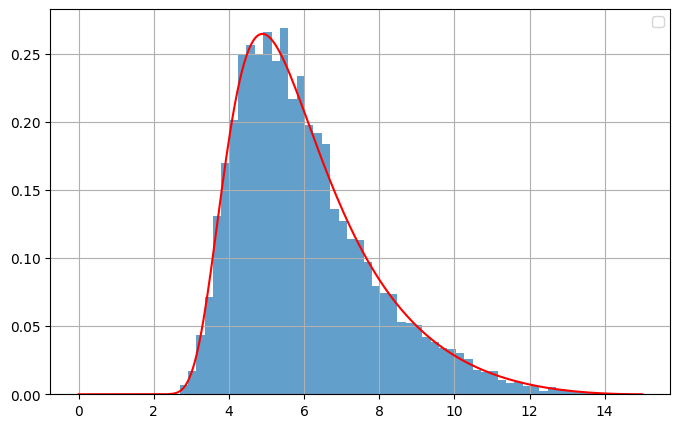

In [6]:
x, z= sp.symbols('x z')

L= 25  
g_2= (6 / (L**3 * gamma(1 / 2))) *x**2 * sp.exp(-(x / L) ** 6)
g_numeric_2 =sp.lambdify(x, g_2, modules=['numpy'])

integral_2, _= quad(g_numeric_2, 0, np.inf)
g_2= g_2 / integral_2 

trans_2= -20 * sp.ln(z / 15)
f_2= g_2.subs(x, trans_2) * sp.Abs(sp.diff(trans_2, z))
f_np_2 = sp.lambdify(z, f_2, modules=['numpy', {'log': np.log, 'Abs': np.abs}])

z_vals_2 =np.geomspace(1e-5, 15, 1000)  
y_vals_2= f_np_2(z_vals_2)

norma_2= np.trapz(y_vals_2, z_vals_2)
f_np_corr_2 =lambda z: f_np_2(z) / norma_2

evals_f_vals_2= np.column_stack((z_vals_2, f_np_corr_2(z_vals_2)))

def proposal_pdf(x, mu, sigma, a, b):
    return truncnorm.pdf(x, (a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)

mu, sigma = 5, 3  
a, b= 1e-5, 15 
proposal_vals= proposal_pdf(z_vals_2, mu, sigma, a,b)

M= np.max(f_np_corr_2(z_vals_2) / proposal_vals)

def rejection_sampling(num_samples, target_pdf, proposal_pdf, mu, sigma, a,b, M):
    samples = []
    while len(samples) < num_samples:
        x= truncnorm.rvs((a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)
        u= np.random.uniform()
        if u<= target_pdf(x) / (M * proposal_pdf(x, mu,sigma, a, b)):
            samples.append(x)
    return np.array(samples)

num_samples= 10000
samples_2= rejection_sampling(num_samples,f_np_corr_2,proposal_pdf, mu,sigma,a,b,M)

plt.figure(figsize=(8, 5))
plt.hist(samples_2, bins=50, density=True, alpha=0.7)
plt.plot(z_vals_2, f_np_corr_2(z_vals_2), color='r')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


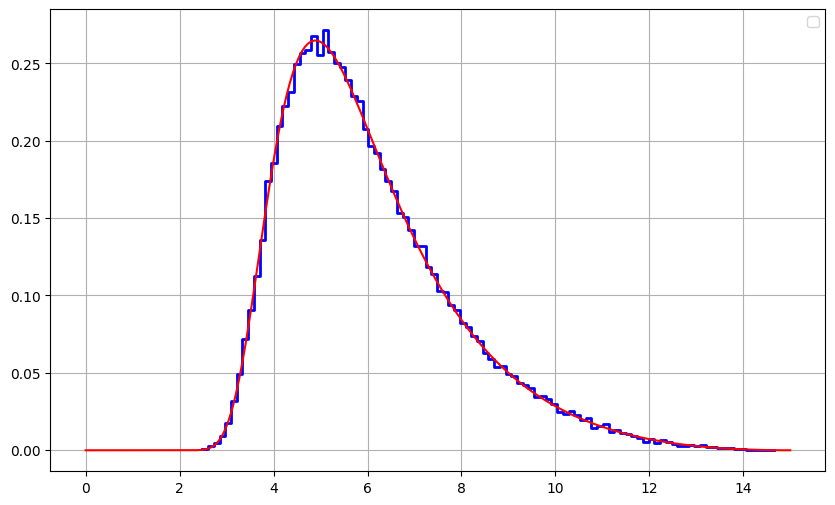

In [7]:
def g_x(x, L, n):
    return (6 / (L**(n+1) * 1.8)) * x**n * np.exp(-(x / L) ** 6)

def comp_norm(L, n):
    integral, _= quad(lambda x: g_x(x, L, n), 0, np.inf)
    return integral

def g_x_norm(x, L, n):
    norm_factor= comp_norm(L, n)
    return g_x(x, L, n) / norm_factor  

def truncated_normal(mu, sigma, a, b, size=1):
    a, b= (a-mu)/sigma, (b-mu)/sigma 
    return truncnorm.rvs(a, b, loc=mu, scale=sigma, size=size)

def sample_gx(L, n, num_samples=100000):
    samples = []
    mu, sigma = 18, 9  # vary mu, sigma to shift the peak and broaden
    a, b = 1e-5, 50    
    while len(samples) < num_samples:
        x= truncated_normal(mu, sigma, a, b)
        u= np.random.uniform(0, 1)
        if u<= g_x_norm(x, L,n) / (2*truncnorm.pdf(x, (a-mu)/sigma,(b-mu)/sigma, loc=mu, scale=sigma)):  # 2*truncnorm.pdf(...) the 2 is chosen to adjust the value of the peak
            samples.append(x)
    return np.array(samples)

L= 25
n= 2
sampled_x= sample_gx(L, n)

B_R= 15 * np.exp(-sampled_x / 20)

def trace_histogram(data, bins=100):
    counts, edges = np.histogram(data, bins=bins, density=True)
    left, right = edges[:-1], edges[1:]
    X= np.array([left, right]).T.flatten()
    Y= np.array([counts, counts]).T.flatten() 
    return X, Y

plt.figure(figsize=(10, 6))

X_BR_2, Y_BR_2= trace_histogram(B_R)

BRR_2= np.column_stack((X_BR_2, Y_BR_2))

plt.plot(X_BR_2, Y_BR_2, color='b', linewidth=2)
plt.plot(z_vals_2, f_np_corr_2(z_vals_2), color='r')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


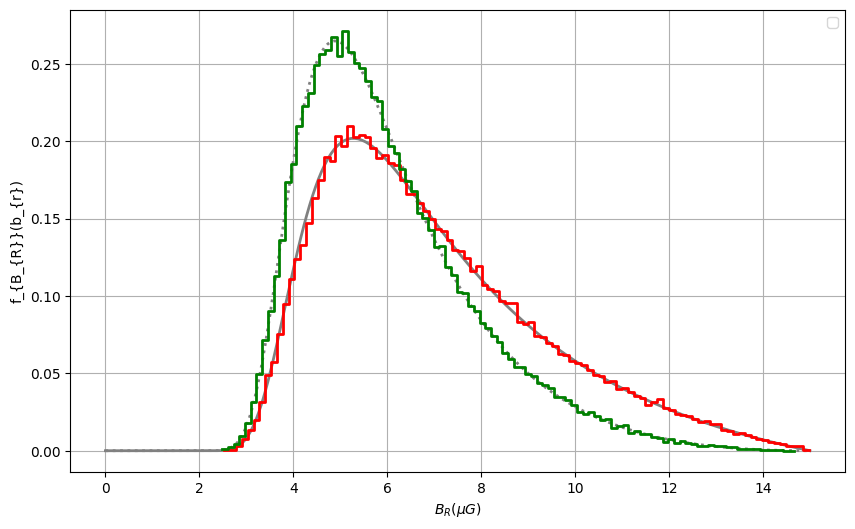

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(z_vals_1, f_np_corr_1(z_vals_1), color='grey', linewidth=2)
plt.plot(z_vals_2, f_np_corr_2(z_vals_2), color='grey', linestyle=':', linewidth=2)
plt.plot(X_BR_1, Y_BR_1, color='red', linewidth=2)
plt.plot(X_BR_2, Y_BR_2, color='green', linewidth=2)
plt.xlabel(r'$B_{R}(\mu G)$')
plt.ylabel(r'f_{B_{R}}(b_{r})')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


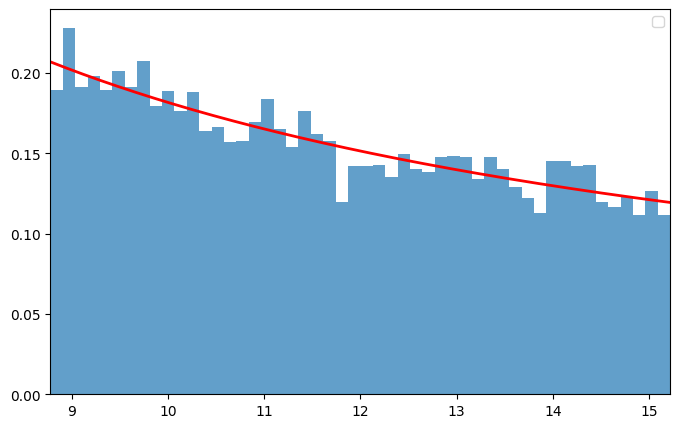

In [3]:
x= sp.Symbol('x')

def original_pdf(r):
    return np.ones_like(r)/11 

def trans(r):
    return 16*np.exp(-r/20)

def trans_pdf(x_values):
    x_trans= -20*sp.log(x/16)
    dx_dr= sp.diff(x_trans, x)
    pdf_x_sym= (1/11)* sp.Abs(dx_dr)
    pdf_x_func= sp.lambdify(x, pdf_x_sym, 'numpy')
    return pdf_x_func(x_values)

def inverse_transform_sampling(n_samples=10000):
    u= np.random.uniform(0, 1, n_samples)  
    r_samples= u * 11+1  # (u * (R_max - R_min)+ R_min)
    x_samples= trans(r_samples)  
    return x_samples

x_min,x_max= 16*np.exp(-12/20),16*np.exp(-1/20)
x_values= np.linspace(x_min,x_max, 1000)
y_trans= trans_pdf(x_values)

samples_3= inverse_transform_sampling()

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_values, y_trans, linewidth=2, color='r')
ax.hist(samples_3, bins=50, density=True, alpha=0.7)
ax.set_xlim(x_min, x_max)  
ax.legend()
plt.show()

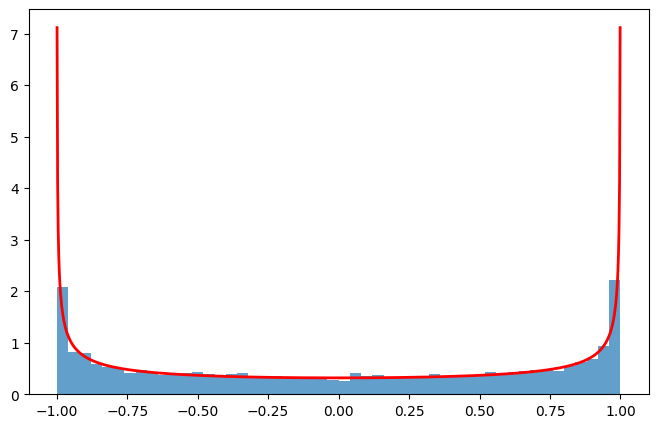

In [4]:
x= sp.symbols('x')

f= 1 / (2 * np.pi) * sp.Abs(1 / sp.diff(sp.cos(x), x))  
f= f.subs(x, sp.acos(x))  
f_np= sp.lambdify(x, f, modules=['numpy', {'Abs': np.abs}])  

integral, _= quad(f_np, -1, 1)
f_np_norm= lambda x: f_np(x) / integral 

def proposal_pdf(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

x_vals= np.linspace(-0.999, 0.999, 1000)  
y_vals= f_np_norm(x_vals)

mu, sigma = 0, 0.7 
M = np.max(y_vals/proposal_pdf(x_vals, mu, sigma)) *5  

def rejection_sampling(num_samples, target_pdf, proposal_pdf, mu, sigma, M):
    samples= []
    while len(samples) < num_samples:
        x= np.random.normal(mu, sigma)  
        if -1<= x<= 1:  
            u= np.random.uniform()
            if u<= target_pdf(x) / (M * proposal_pdf(x, mu, sigma)):
                samples.append(x)
    return np.array(samples)

num_samples= 10000
samples= rejection_sampling(num_samples, f_np_norm, proposal_pdf, mu, sigma, M)

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.7)
plt.plot(x_vals, y_vals,linewidth=2, color='r')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


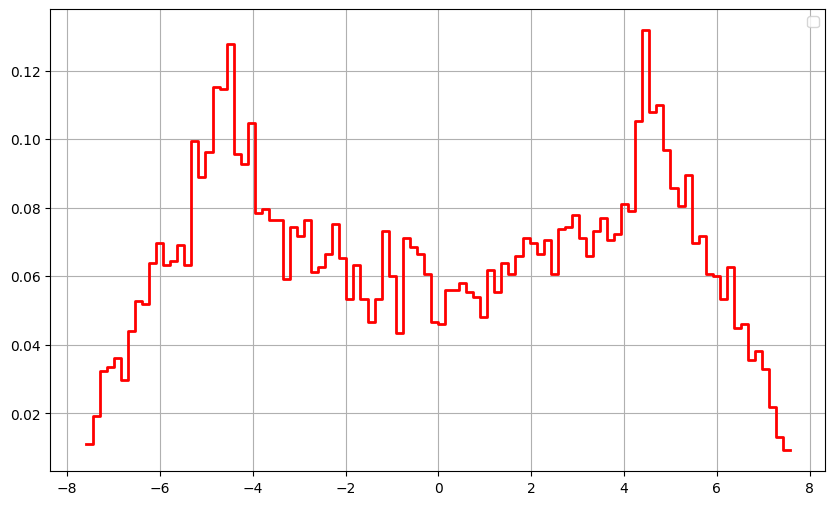

In [5]:
B_parallel_samples = - samples_3 * samples * 0.5 # * samples_3

def trace_histogram(data, bins=100):
    counts, edges = np.histogram(data, bins=bins, density=True)
    left, right = edges[:-1], edges[1:]
    X= np.array([left, right]).T.flatten()
    Y= np.array([counts, counts]).T.flatten()
    return X, Y

X_BU, Y_BU= trace_histogram(B_parallel_samples)
np.savetxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_red_u.txt", np.column_stack((X_BU, Y_BU)), header="X_BU Y_BU")
loaded_data = np.loadtxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_red_u.txt", skiprows=1)
X_BU_loaded, Y_BU_loaded= loaded_data[:, 0],loaded_data[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(X_BU_loaded,Y_BU_loaded, color='r',linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


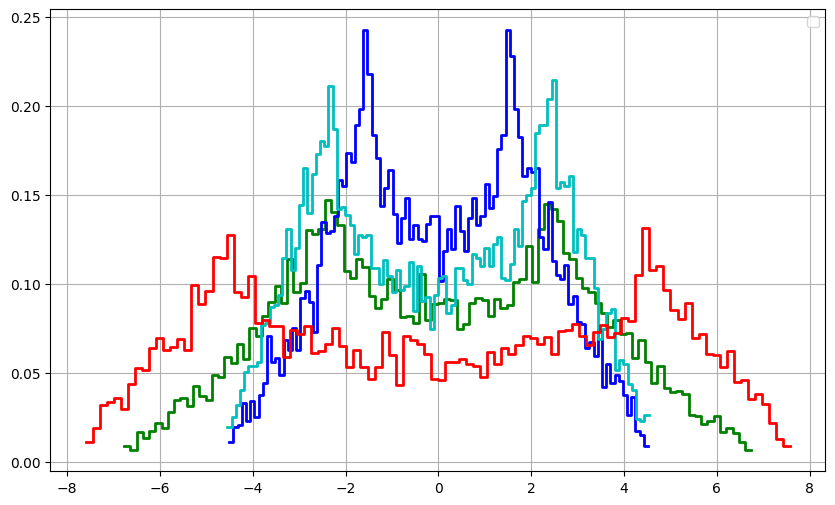

In [8]:
loaded_data_green = np.loadtxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_green_u.txt", skiprows=1)
loaded_data_blue = np.loadtxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_blue_u.txt", skiprows=1)
loaded_data_sky_blue = np.loadtxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_sky_blue_u.txt", skiprows=1)
loaded_data_red = np.loadtxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_red_u.txt", skiprows=1)

X_BU_green, Y_BU_green= loaded_data_green[:, 0],loaded_data_green[:, 1]
X_BU_blue, Y_BU_blue= loaded_data_blue[:, 0],loaded_data_blue[:, 1]
X_BU_sky_blue, Y_BU_sky_blue= loaded_data_sky_blue[:, 0],loaded_data_sky_blue[:, 1]
X_BU_red, Y_BU_red= loaded_data_red[:, 0],loaded_data_red[:, 1]


plt.figure(figsize=(10, 6))
plt.plot(X_BU_green,Y_BU_green, color='g',linewidth=2)
plt.plot(X_BU_blue,Y_BU_blue, color='b',linewidth=2)
plt.plot(X_BU_sky_blue,Y_BU_sky_blue, color='c',linewidth=2)
plt.plot(X_BU_red,Y_BU_red, color='r',linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

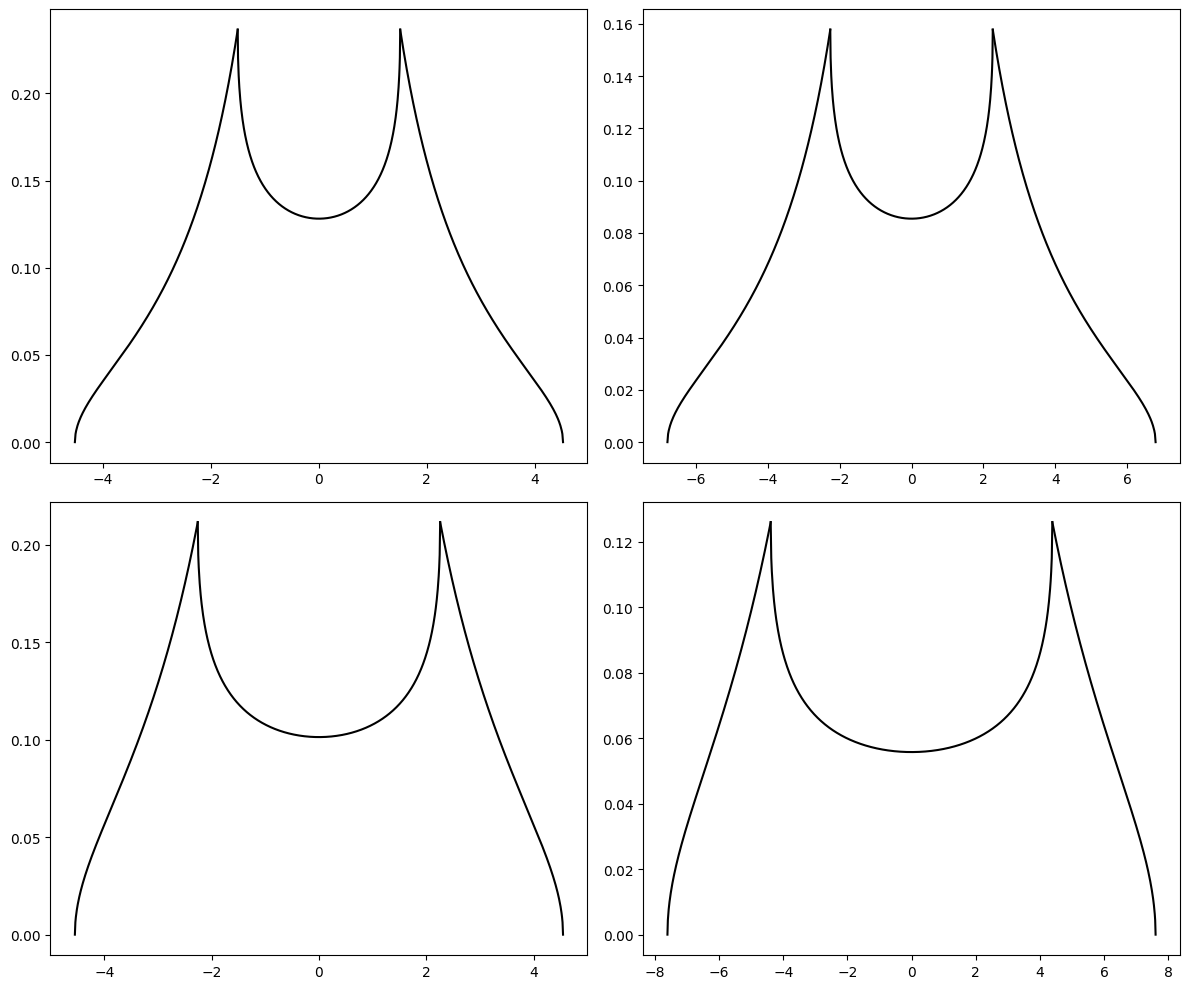

In [13]:
def f_x(x, B0, R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))
    term1= np.arcsin(x/(B0*0.5*np.exp(-R_max/20)))
    term2= np.arcsin(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * (term1 - term2)

def g_x(x, B0,R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))
    term= np.arccos(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * term

cases = [(10, 2, 24),(15, 2, 24),(15, 10, 24),(16, 1, 12)]
fig, axes= plt.subplots(2,2, figsize=(12, 10))

for i, (B0, R_min,R_max) in enumerate(cases):
    ax = axes[i//2, i%2]

    x1_min= -B0*0.5*np.exp(-R_max/ 20)
    x1_max= B0*0.5*np.exp(-R_max/ 20)
    x2_min= -B0*0.5*np.exp(-R_min/ 20)
    x2_max= B0*0.5*np.exp(-R_min / 20)

    x1= np.linspace(x1_min,x1_max, 500)
    x2_left= np.linspace(x2_min,x1_min, 250)
    x2_right= np.linspace(x1_max,x2_max, 250)

    f_vals= f_x(x1, B0,R_min, R_max)
    g_vals_left= g_x(x2_left, B0,R_min, R_max)
    g_vals_right= g_x(x2_right,B0,R_min, R_max)

    ax.plot(x1, f_vals,color='black')
    ax.plot(x2_left,g_vals_left,color='black')
    ax.plot(x2_right,g_vals_right,color='black')

plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


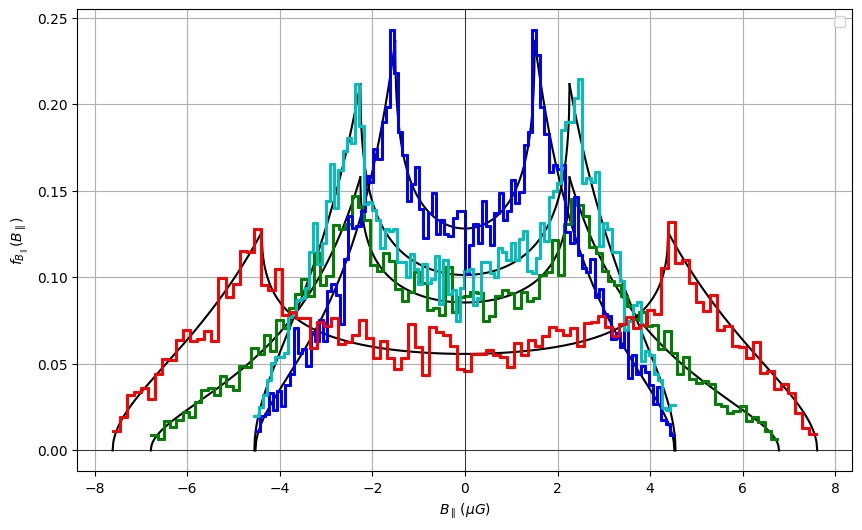

In [9]:
def f_x(x, B0, R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))
    term1= np.arcsin(x/(B0*0.5*np.exp(-R_max/20)))
    term2= np.arcsin(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * (term1 - term2)

def g_x(x, B0,R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))
    term= np.arccos(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * term
    
cases = [(10, 2, 24),(15, 2, 24),(15, 10, 24),(16, 1, 12)]
plt.figure(figsize=(10, 6))
colors = ['black', 'black', 'black', 'black']

for (B0, R_min, R_max), color in zip(cases, colors):

    x1_min= -B0*0.5*np.exp(-R_max/ 20)
    x1_max= B0*0.5*np.exp(-R_max/ 20)
    x2_min= -B0*0.5*np.exp(-R_min/ 20)
    x2_max= B0*0.5*np.exp(-R_min / 20)

    x1= np.linspace(x1_min,x1_max, 500)
    x2_left= np.linspace(x2_min,x1_min, 250)
    x2_right= np.linspace(x1_max,x2_max, 250)

    f_vals= f_x(x1, B0,R_min, R_max)
    g_vals_left= g_x(x2_left, B0,R_min, R_max)
    g_vals_right= g_x(x2_right,B0,R_min, R_max)

    plt.plot(x1, f_vals, color=color)
    plt.plot(x2_left, g_vals_left, color=color)
    plt.plot(x2_right, g_vals_right, color=color)
    
    loaded_data_green = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_green_u.txt", skiprows=1)
    loaded_data_blue = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_blue_u.txt", skiprows=1)
    loaded_data_sky_blue = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_sky_blue_u.txt", skiprows=1)
    loaded_data_red = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_data_red_u.txt", skiprows=1)

    X_BU_green, Y_BU_green= loaded_data_green[:, 0],loaded_data_green[:, 1]
    X_BU_blue, Y_BU_blue= loaded_data_blue[:, 0],loaded_data_blue[:, 1]
    X_BU_sky_blue, Y_BU_sky_blue= loaded_data_sky_blue[:, 0],loaded_data_sky_blue[:, 1]
    X_BU_red, Y_BU_red= loaded_data_red[:, 0],loaded_data_red[:, 1]

    plt.plot(X_BU_green,Y_BU_green, color='g',linewidth=2)
    plt.plot(X_BU_blue,Y_BU_blue, color='b',linewidth=2)
    plt.plot(X_BU_sky_blue,Y_BU_sky_blue, color='c',linewidth=2)
    plt.plot(X_BU_red,Y_BU_red, color='r',linewidth=2)

plt.ylabel(r'$f_{B_{\parallel}}(B_{\parallel})$')
plt.xlabel(r'$B_{\parallel} \, (\mu G)$')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid()
plt.show()

In [5]:
test_peak= -16*0.5*np.exp(-12/ 20)
print(test_peak)

-4.390493088752211


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


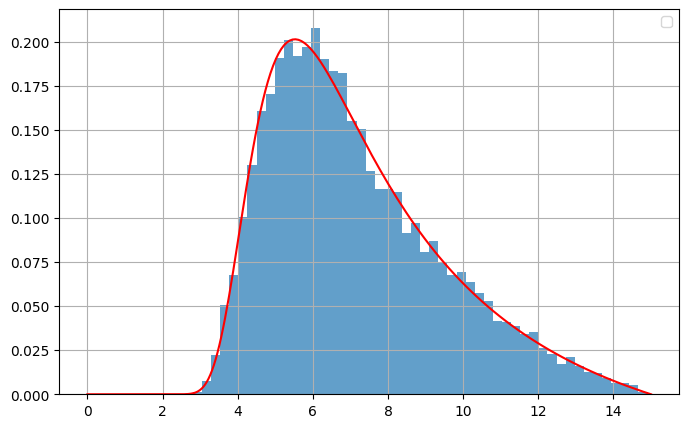

In [3]:
x, z= sp.symbols('x z')

L= 24 
g_1= (6 / (L**2 * gamma(1 / 3))) *x * sp.exp(-(x / L) ** 6)
g_numeric_1 =sp.lambdify(x, g_1, modules=['numpy'])

integral_1, _= quad(g_numeric_1, 0, np.inf)
g_1= g_1/ integral_1  

trans_1= -20* sp.ln(z/ 15)
f_1= g_1.subs(x, trans_1) * sp.Abs(sp.diff(trans_1, z))
f_np_1 = sp.lambdify(z,f_1, modules=['numpy',{'log': np.log, 'Abs': np.abs}])

z_vals_1 =np.geomspace(1e-5,15,  1000) 
y_vals_1= f_np_1(z_vals_1)

norma_1= np.trapz(y_vals_1, z_vals_1)
f_np_corr_1 =lambda z: f_np_1(z) / norma_1

evals_f_vals_1= np.column_stack((z_vals_1, f_np_corr_1(z_vals_1)))

def proposal_pdf(x, mu, sigma, a, b):
    return truncnorm.pdf(x, (a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)

mu, sigma = 5, 3  
a, b= 1e-5, 15  
proposal_vals= proposal_pdf(z_vals_1, mu, sigma, a,b)

M= np.max(f_np_corr_1(z_vals_1)/ proposal_vals)

def rejection_sampling(num_samples, target_pdf, proposal_pdf, mu, sigma, a,b, M):
    samples= []
    while len(samples) < num_samples:
        x= truncnorm.rvs((a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)
        u= np.random.uniform()
        if u<= target_pdf(x) / (M*proposal_pdf(x, mu,sigma, a, b)):
            samples.append(x)
    return np.array(samples)

num_samples= 10000
samples_1= rejection_sampling(num_samples,f_np_corr_1,proposal_pdf, mu,sigma,a,b,M)

plt.figure(figsize=(8, 5))
plt.hist(samples_1, bins=50, density=True, alpha=0.7)
plt.plot(z_vals_1, f_np_corr_1(z_vals_1), color='r')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


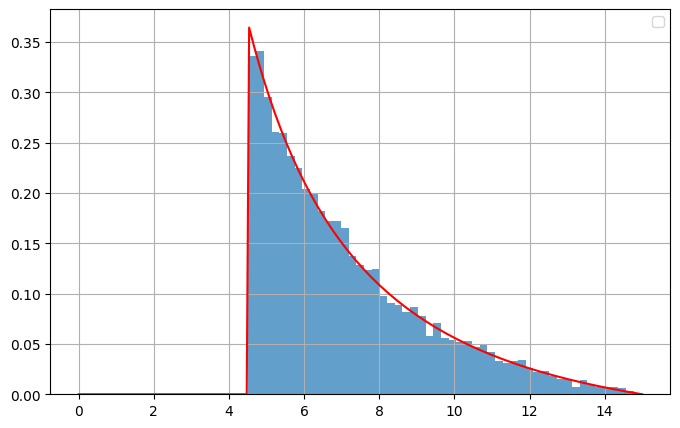

In [3]:
x,z= sp.symbols('x z')
L= 24

g_2= sp.Piecewise(((2/L**2)*x, (x>= 0)&(x<= L)), (0, True))
g_numeric_2= sp.lambdify(x, g_2, modules=["numpy"])
integral_2, _= quad(g_numeric_2, 0, L)

g_2_normalized= sp.Piecewise((g_2/integral_2, (x>= 0)&(x<= L)), (0, True))
g_numeric_2_norm= sp.lambdify(x, g_2_normalized, modules=["numpy"])

trans_2= -20*sp.ln(z / 15)
d_trans_2_dz= sp.diff(trans_2, z)
f_2= sp.Piecewise((g_2_normalized.subs(x, trans_2)*sp.Abs(d_trans_2_dz),(trans_2>= 0)&(trans_2<= L)), (0, True))
f_np_2= sp.lambdify(z, f_2, modules=["numpy", {'log': np.log, 'Abs': np.abs}])

z_vals_2= np.geomspace(1e-5, 15, 1000)
y_vals_2= f_np_2(z_vals_2)

norma_2= np.trapz(y_vals_2, z_vals_2)
f_np_corr_2 = lambda z: f_np_2(z) / norma_2

def proposal_pdf(x, mu, sigma, a, b):
    return truncnorm.pdf(x,(a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)

mu,sigma= 5, 3
a,b= 1e-5, 15
proposal_vals = proposal_pdf(z_vals_2,mu, sigma, a,b)

M= np.max(f_np_corr_2(z_vals_2)/ proposal_vals)

def rejection_sampling(num_samples,target_pdf, proposal_pdf, mu,sigma, a,b, M):
    samples= []
    while len(samples)< num_samples:
        x= truncnorm.rvs((a-mu)/sigma,(b-mu)/sigma,loc=mu, scale=sigma)
        u= np.random.uniform()
        if u<= target_pdf(x)/(M*proposal_pdf(x,mu, sigma, a,b)):
            samples.append(x)
    return np.array(samples)

num_samples= 10000
samples_2= rejection_sampling(num_samples,f_np_corr_2, proposal_pdf, mu,sigma, a,b, M)

plt.figure(figsize=(8, 5))
plt.hist(samples_2, bins=50, density=True, alpha=0.7)
plt.plot(z_vals_2, f_np_corr_2(z_vals_2), color='r')
plt.legend()
plt.grid(True)
plt.show()

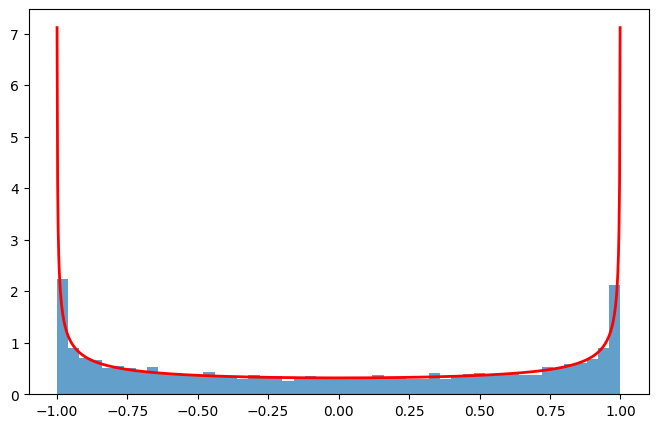

In [4]:
x= sp.symbols('x')

f= 1 / (2 * np.pi) * sp.Abs(1 / sp.diff(sp.cos(x), x))  
f= f.subs(x, sp.acos(x))  
f_np= sp.lambdify(x, f, modules=['numpy', {'Abs': np.abs}])  

integral, _= quad(f_np, -1, 1)
f_np_norm= lambda x: f_np(x) / integral 

def proposal_pdf(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

x_vals= np.linspace(-0.999, 0.999, 1000)  
y_vals= f_np_norm(x_vals)

mu, sigma = 0, 0.7 
M = np.max(y_vals/proposal_pdf(x_vals, mu, sigma)) *5  

def rejection_sampling(num_samples, target_pdf, proposal_pdf, mu, sigma, M):
    samples= []
    while len(samples) < num_samples:
        x= np.random.normal(mu, sigma)  
        if -1<= x<= 1:  
            u= np.random.uniform()
            if u<= target_pdf(x) / (M * proposal_pdf(x, mu, sigma)):
                samples.append(x)
    return np.array(samples)

num_samples= 10000
samples= rejection_sampling(num_samples, f_np_norm, proposal_pdf, mu, sigma, M)

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.7)
plt.plot(x_vals, y_vals,linewidth=2, color='r')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


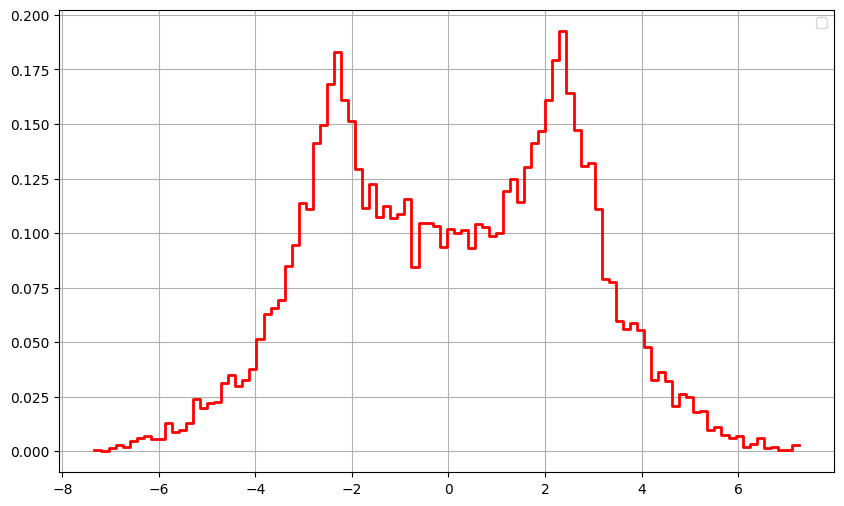

In [5]:
B_parallel_samples = - samples_2 * samples * 0.5 # * samples_3

def trace_histogram(data, bins=100):
    counts, edges = np.histogram(data, bins=bins, density=True)
    left, right = edges[:-1], edges[1:]
    X= np.array([left, right]).T.flatten()
    Y= np.array([counts, counts]).T.flatten()
    return X, Y

X_BU, Y_BU= trace_histogram(B_parallel_samples)
np.savetxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_hardcutoff.txt", np.column_stack((X_BU, Y_BU)), header="X_BU Y_BU")
loaded_data = np.loadtxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_hardcutoff.txt", skiprows=1)
X_BU_loaded, Y_BU_loaded= loaded_data[:, 0],loaded_data[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(X_BU_loaded,Y_BU_loaded, color='r',linewidth=2)
# plt.plot(X_BU,Y_BU, color='r',linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


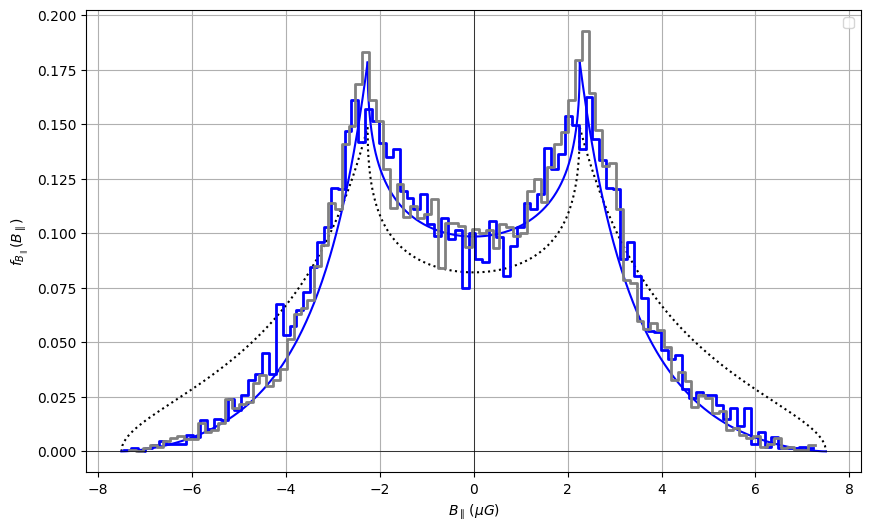

In [8]:
def f_x(x, B0, R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))
    term1= np.arcsin(x/(B0*0.5*np.exp(-R_max/20)))
    term2= np.arcsin(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * (term1 - term2)

def g_x(x, B0,R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))
    term= np.arccos(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * term

def f_x1(x, B0, R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))*(R_max/20)
    term1= np.arcsin(x/(B0*0.5*np.exp(-R_max/20)))
    term2= np.arcsin(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * (term1 - term2)

def g_x1(x, B0,R_min, R_max):
    x= np.abs(x)  
    factor= 20/(x*np.pi*(R_max-R_min))*np.log((B0*0.5)/x)
    term= np.arccos(x/(B0*0.5*np.exp(-R_min/20)))
    return factor * term
    
cases = [(15, 0, 24)]
plt.figure(figsize=(10, 6))
colors = ['blue']

for (B0, R_min, R_max), color in zip(cases, colors):

    x1_min= -B0*0.5*np.exp(-R_max/ 20)
    x1_max= B0*0.5*np.exp(-R_max/ 20)
    x2_min= -B0*0.5*np.exp(-R_min/ 20)
    x2_max= B0*0.5*np.exp(-R_min / 20)

    x1= np.linspace(x1_min,x1_max, 500)
    x2_left= np.linspace(x2_min,x1_min, 250)
    x2_right= np.linspace(x1_max,x2_max, 250)

    f_vals= f_x(x1, B0,R_min, R_max)
    g_vals_left= g_x(x2_left, B0,R_min, R_max)
    g_vals_right= g_x(x2_right,B0,R_min, R_max)

    plt.plot(x1, f_vals, color='black',linestyle=':')
    plt.plot(x2_left, g_vals_left, color='black',linestyle=':')
    plt.plot(x2_right, g_vals_right, color='black',linestyle=':')

    f_vals1= f_x1(x1, B0,R_min, R_max)
    g_vals_left1= g_x1(x2_left, B0,R_min, R_max)
    g_vals_right1= g_x1(x2_right,B0,R_min, R_max)

    plt.plot(x1, f_vals1, color=color)
    plt.plot(x2_left, g_vals_left1, color=color)
    plt.plot(x2_right, g_vals_right1, color=color)
    
    loaded_data_smoothcutoff = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_smoothcutoff.txt", skiprows=1)
    loaded_data_hardcutoff = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/B_PARALLEL/B_parallel_hardcutoff.txt", skiprows=1)

    X_BU_smoothcutoff, Y_BU_smoothcutoff= loaded_data_smoothcutoff[:, 0],loaded_data_smoothcutoff[:, 1]
    X_BU_hardcutoff, Y_BU_hardcutoff= loaded_data_hardcutoff[:, 0],loaded_data_hardcutoff[:, 1]

    plt.plot(X_BU_smoothcutoff,Y_BU_smoothcutoff, color='blue',linewidth=2)
    plt.plot(X_BU_hardcutoff,Y_BU_hardcutoff, color='grey',linewidth=2)

plt.ylabel(r'$f_{B_{\parallel}}(B_{\parallel})$')
plt.xlabel(r'$B_{\parallel} \, (\mu G)$')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


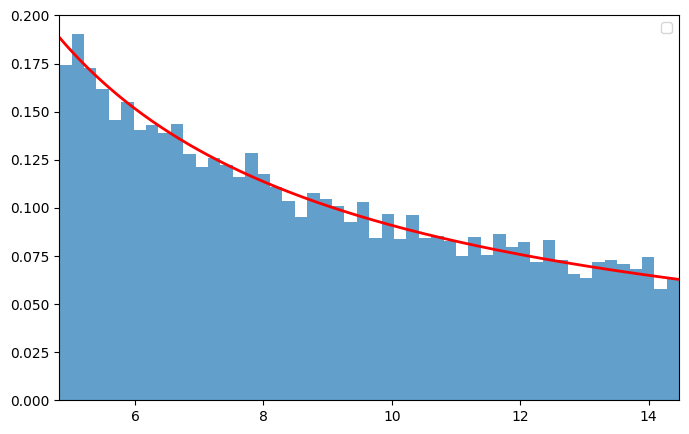

In [3]:
x= sp.Symbol('x')

def original_pdf(r):
    return np.ones_like(r)/11 

def trans(r):
    return 16*np.exp(-r/10)

def trans_pdf(x_values):
    x_trans= -10*sp.log(x/16)
    dx_dr= sp.diff(x_trans, x)
    pdf_x_sym= (1/11)* sp.Abs(dx_dr)
    pdf_x_func= sp.lambdify(x, pdf_x_sym, 'numpy')
    return pdf_x_func(x_values)

def inverse_transform_sampling(n_samples=10000):
    u= np.random.uniform(0, 1, n_samples)  
    r_samples= u * 11+1  # (u * (R_max - R_min)+ R_min)
    x_samples= trans(r_samples)  
    return x_samples

x_min,x_max= 16*np.exp(-12/10),16*np.exp(-1/10)
x_values= np.linspace(x_min,x_max, 1000)
y_trans= trans_pdf(x_values)

samples_3= inverse_transform_sampling()

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_values, y_trans, linewidth=2, color='r')
ax.hist(samples_3, bins=50, density=True, alpha=0.7)
ax.set_xlim(x_min, x_max)  
ax.legend()
plt.show()

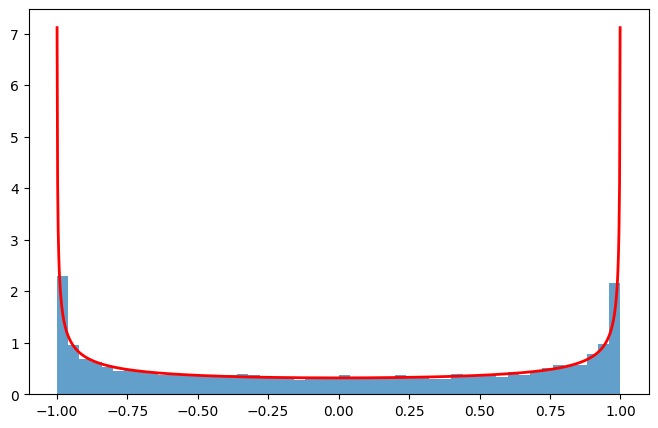

In [4]:
x= sp.symbols('x')

f= 1 / (2 * np.pi) * sp.Abs(1 / sp.diff(sp.cos(x), x))  
f= f.subs(x, sp.acos(x))  
f_np= sp.lambdify(x, f, modules=['numpy', {'Abs': np.abs}])  

integral, _= quad(f_np, -1, 1)
f_np_norm= lambda x: f_np(x) / integral 

def proposal_pdf(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

x_vals= np.linspace(-0.999, 0.999, 1000)  
y_vals= f_np_norm(x_vals)

mu, sigma = 0, 0.7 
M = np.max(y_vals/proposal_pdf(x_vals, mu, sigma)) *5  

def rejection_sampling(num_samples, target_pdf, proposal_pdf, mu, sigma, M):
    samples= []
    while len(samples) < num_samples:
        x= np.random.normal(mu, sigma)  
        if -1<= x<= 1:  
            u= np.random.uniform()
            if u<= target_pdf(x) / (M * proposal_pdf(x, mu, sigma)):
                samples.append(x)
    return np.array(samples)

num_samples= 10000
samples= rejection_sampling(num_samples, f_np_norm, proposal_pdf, mu, sigma, M)

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.7)
plt.plot(x_vals, y_vals,linewidth=2, color='r')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


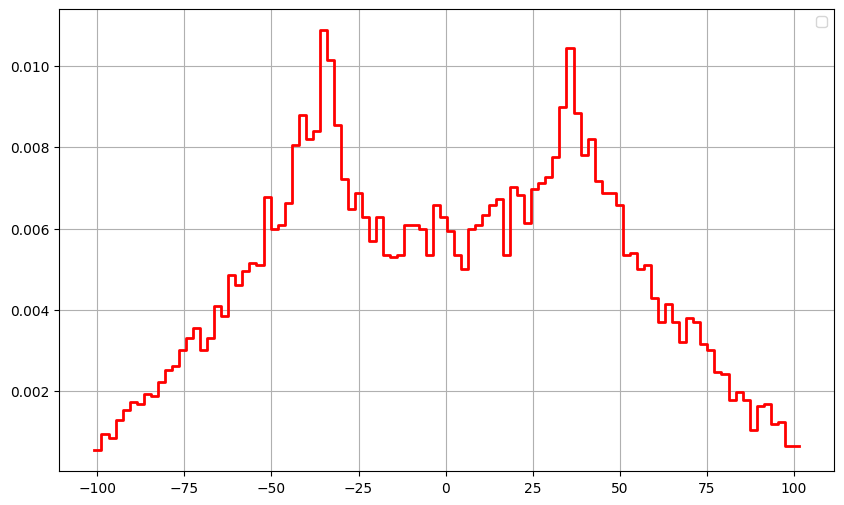

In [5]:
B_parallel_samples = - 0.81*0.03*samples_3 * samples *500 *0.57735 # * samples_3

def trace_histogram(data, bins=100):
    counts, edges = np.histogram(data, bins=bins, density=True)
    left, right = edges[:-1], edges[1:]
    X= np.array([left, right]).T.flatten()
    Y= np.array([counts, counts]).T.flatten()
    return X, Y

X_BU, Y_BU= trace_histogram(B_parallel_samples)
np.savetxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/RM_SINGLE/RM_data_red.txt", np.column_stack((X_BU, Y_BU)), header="X_BU Y_BU")
loaded_data = np.loadtxt("/Users/hshishir/Desktop/MSc THESIS/CODE/BASU_RES/RM_SINGLE/RM_data_red.txt", skiprows=1)
X_BU_loaded, Y_BU_loaded= loaded_data[:, 0],loaded_data[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(X_BU_loaded,Y_BU_loaded, color='r',linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


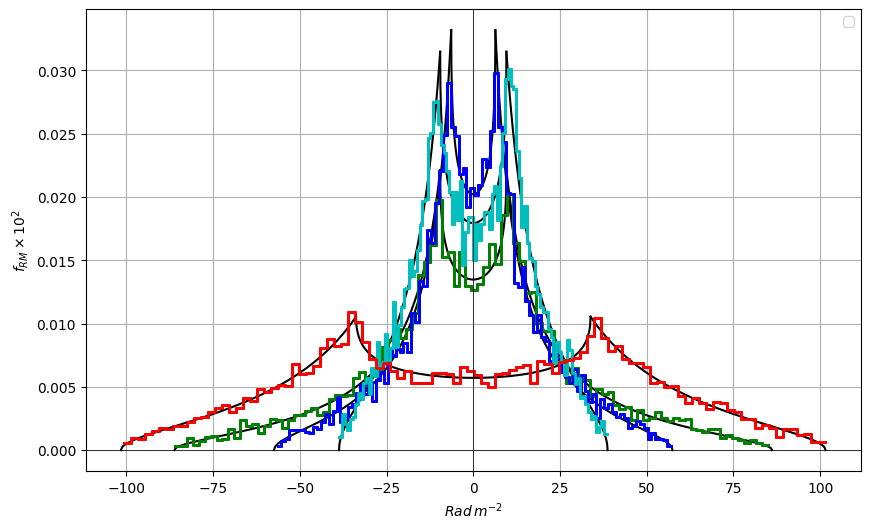

In [7]:
def f_x(x, B0, R_min, R_max):
    x= np.abs(x)  
    factor= 10/(x*np.pi*(R_max-R_min))
    term1= np.arcsin(x/(0.81*0.03*B0*500*0.57735*np.exp(-R_max/10)))
    term2= np.arcsin(x/(0.81*0.03*B0*500*0.57735*np.exp(-R_min/10)))
    return factor * (term1 - term2)

def g_x(x, B0,R_min, R_max):
    x= np.abs(x)  
    factor= 10/(x*np.pi*(R_max-R_min))
    term= np.arccos(x/(0.81*0.03*B0*500*0.57735*np.exp(-R_min/10)))
    return factor * term
    
cases = [(10, 2, 24),(15, 2, 24),(15, 10, 24),(16, 1, 12)]
plt.figure(figsize=(10, 6))
colors = ['black', 'black', 'black', 'black']

for (B0, R_min, R_max), color in zip(cases, colors):

    x1_min= -0.81*0.03*B0*500*0.57735*np.exp(-R_max/ 10)
    x1_max= 0.81*0.03*B0*500*0.57735*np.exp(-R_max/ 10)
    x2_min= -0.81*0.03*B0*500*0.57735*np.exp(-R_min/ 10)
    x2_max= 0.81*0.03*B0*500*0.57735*np.exp(-R_min / 10)

    x1= np.linspace(x1_min,x1_max, 500)
    x2_left= np.linspace(x2_min,x1_min, 250)
    x2_right= np.linspace(x1_max,x2_max, 250)

    f_vals= f_x(x1, B0,R_min, R_max)
    g_vals_left= g_x(x2_left, B0,R_min, R_max)
    g_vals_right= g_x(x2_right,B0,R_min, R_max)

    plt.plot(x1, f_vals, color=color)
    plt.plot(x2_left, g_vals_left, color=color)
    plt.plot(x2_right, g_vals_right, color=color)
    
    loaded_data_green = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/RM_SINGLE/RM_data_green.txt", skiprows=1)
    loaded_data_blue = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/RM_SINGLE/RM_data_blue.txt", skiprows=1)
    loaded_data_sky_blue = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/RM_SINGLE/RM_data_skyblue.txt", skiprows=1)
    loaded_data_red = np.loadtxt("/Users/hshishir/Desktop/MSc_THESIS/CODE/BASU_RES/RM_SINGLE/RM_data_red.txt", skiprows=1)

    X_BU_green, Y_BU_green= loaded_data_green[:, 0],loaded_data_green[:, 1]
    X_BU_blue, Y_BU_blue= loaded_data_blue[:, 0],loaded_data_blue[:, 1]
    X_BU_sky_blue, Y_BU_sky_blue= loaded_data_sky_blue[:, 0],loaded_data_sky_blue[:, 1]
    X_BU_red, Y_BU_red= loaded_data_red[:, 0],loaded_data_red[:, 1]

    plt.plot(X_BU_green,Y_BU_green, color='g',linewidth=2)
    plt.plot(X_BU_blue,Y_BU_blue, color='b',linewidth=2)
    plt.plot(X_BU_sky_blue,Y_BU_sky_blue, color='c',linewidth=2)
    plt.plot(X_BU_red,Y_BU_red, color='r',linewidth=2)

plt.ylabel(r'$f_{RM} \times 10^2 $')
plt.xlabel(r'$Rad \, m^{-2}$')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid()
plt.show()